In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

In [2]:
import kaggle

OSError: ignored

In [3]:
! mv kaggle.json /root/.kaggle

In [4]:
import kaggle

In [5]:
! kaggle competitions download -c dog-breed-identification

100% 690M/691M [00:07<00:00, 130MB/s]
100% 691M/691M [00:07<00:00, 98.0MB/s]


In [6]:
! unzip -q dog-breed-identification.zip

In [7]:

df=pd.read_csv("labels.csv")

In [8]:
df.sample(5)

,id,breed
6257,9e13beffb5b1aeda1aceeec82648b058,shetland_sheepdog
6194,9c10668d7a4038549c8349f9037bf33d,pekinese
3809,5e39f1e798ab4ec2b7264d07591e62f0,gordon_setter
9406,ebfc57d72a4167ec2f738f2adec52e31,toy_poodle
3190,4ec829615f7cc33a25c62e8f111db50d,english_setter


In [9]:
df.id=df.id+".jpg"

In [10]:
df.sample(5)

,id,breed
6824,ab5c5ee4b0431f391fde0ba59a253907.jpg,toy_poodle
6364,a064e19920ce6da2dd7cca371ff9efd4.jpg,bernese_mountain_dog
1545,2637cc0c82e54086454cd271e2dcb61a.jpg,italian_greyhound
9715,f48432fa098e002cc0d21d1258633697.jpg,kuvasz
7277,b646b8f2863d2e5ccf87b79024f4d517.jpg,german_short-haired_pointer


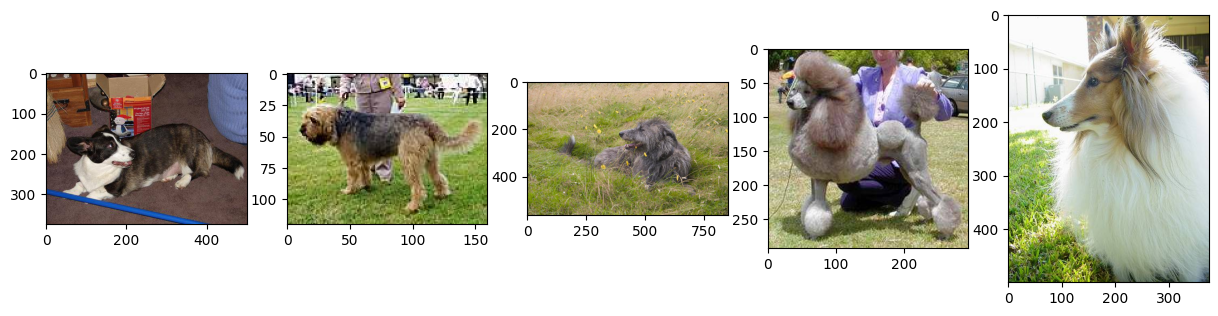

In [11]:
i=1
plt.figure(figsize=(15,10))
for name in df.sample(5)['id']:
  image="train/"+name
  image=cv2.imread(image)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.subplot(1,5,i)
  plt.imshow(image)
  i+=1

1. Input

In [12]:
input_shape=(375, 325)

In [13]:
input=tf.keras.layers.Input((375, 375, 3), name="Input")

2. VGG

In [14]:
#2.1
vgg_pre_process=tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name='VGG_PreProcess') (input)
#2.2
vgg_model=tf.keras.applications.VGG16(include_top=False, input_shape=(375, 375, 3))
vgg_model.trainable=False
vgg=vgg_model (vgg_pre_process)
#2.3
vgg_avg=tf.keras.layers.GlobalAveragePooling2D(name="VGG_Average") (vgg)

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
vgg_model.output_shape

(None, 11, 11, 512)

3. ResNet

In [16]:
#3.1
resnet_pre_process=tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, name="Resnet_PreProcess") (input)
#3.2
resnet_model=tf.keras.applications.ResNet50(include_top=False, input_shape=(375, 375, 3))
resnet_model.trainable=False
resnet= resnet_model (resnet_pre_process)
#3.3
resnet_avg=tf.keras.layers.GlobalAveragePooling2D(name="Resent_Average") (resnet)

94765736/94765736 [==============================] - 0s 0us/step


4. Concatination

In [17]:
resnet_model.output_shape

(None, 12, 12, 2048)

In [18]:
concat=tf.keras.layers.Concatenate( name="Concat") ([vgg_avg, resnet_avg])

5. Dense Layers

In [19]:
#drop1=tf.keras.layers.Dropout(0.5, name="DropOut_1") (concat)
dense1=tf.keras.layers.Dense(512, activation="relu", name="Hidden_1") (concat)
drop2=tf.keras.layers.Dropout(0.25, name="DropOut_2") (dense1)
dense2=tf.keras.layers.Dense(256, activation="relu", name="Hidden_2") (drop2)
drop3=tf.keras.layers.Dropout(0.25, name="DropOut_3") (dense2)
output=tf.keras.layers.Dense(120, activation="softmax", name="Output") (drop3)

6. Final Model

In [20]:
final_model=tf.keras.models.Model(inputs=[input],
                                  outputs=[output])

In [21]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 375, 375, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG_PreProcess (Lambda)        (None, 375, 375, 3)  0           ['Input[0][0]']                  
                                                                                                  
 Resnet_PreProcess (Lambda)     (None, 375, 375, 3)  0           ['Input[0][0]']                  
                                                                                                  
 vgg16 (Functional)             (None, 11, 11, 512)  14714688    ['VGG_PreProcess[0][0]']     

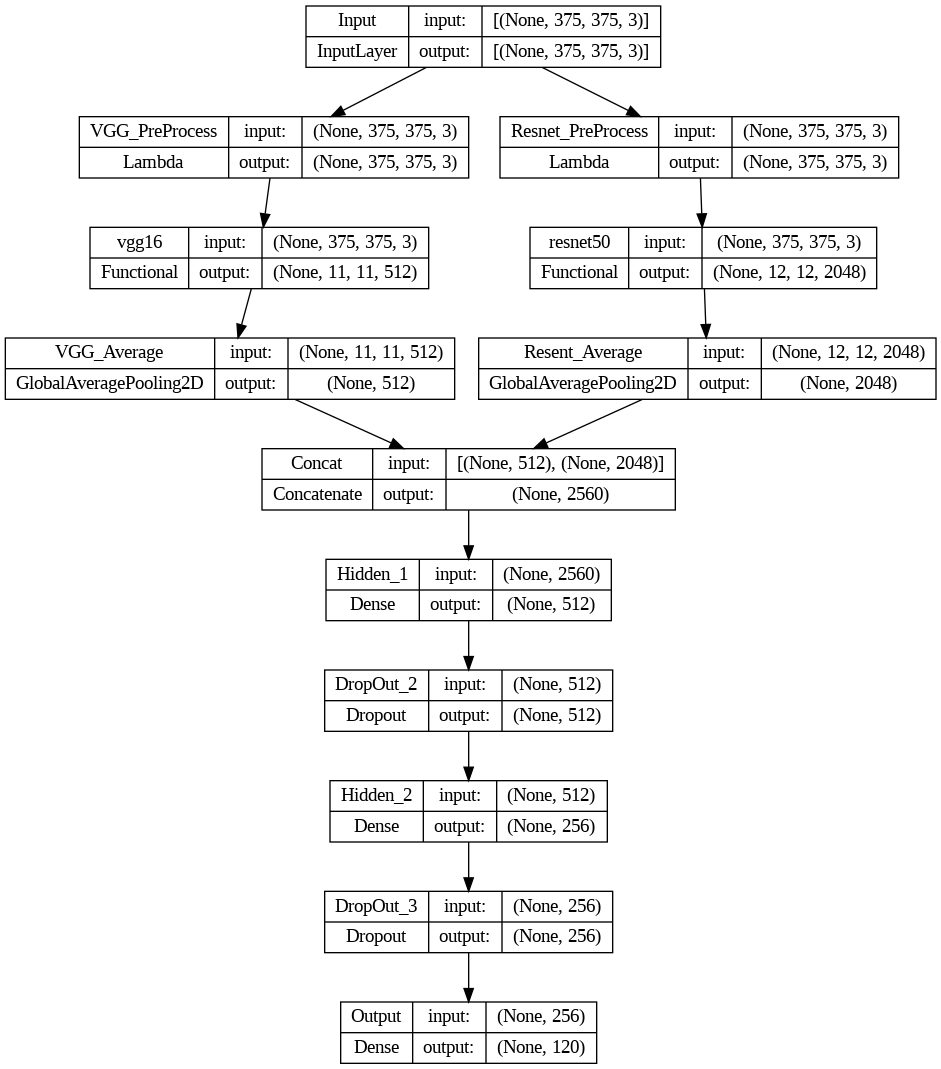

In [22]:
tf.keras.utils.plot_model(final_model, show_layer_names=True, show_shapes=True)

7. IDG

In [23]:
idg=tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1, rotation_range=30, horizontal_flip=True)

In [24]:
train_idg=idg.flow_from_dataframe(dataframe=df,
                                  directory='train/',
                                  x_col='id',
                                  y_col='breed',
                                  target_size=input_shape,
                                  batch_size=64,
                                  subset='training',
                                  )

Found 9200 validated image filenames belonging to 120 classes.


In [25]:
val_idg=idg.flow_from_dataframe(dataframe=df,
                                  directory='train/',
                                  x_col='id',
                                  y_col='breed',
                                  target_size=input_shape,
                                  batch_size=64,
                                  subset='validation',
                                  )

Found 1022 validated image filenames belonging to 120 classes.


8. Compile

In [26]:
final_model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=["acc"])

Mounted at /content/drive


In [28]:
ckpt=tf.keras.callbacks.ModelCheckpoint("Dogbreed", monitor="val_loss", save_best_only=True)

9. Train

In [29]:
final_model.fit(train_idg, batch_size=64, epochs=15, validation_data=val_idg, callbacks=[ckpt])

Epoch 1/15
144/144 [==============================] - ETA: 0s - loss: 4.4885 - acc: 0.0678

144/144 [==============================] - 486s 3s/step - loss: 4.4885 - acc: 0.0678 - val_loss: 3.5045 - val_acc: 0.2613
Epoch 2/15
144/144 [==============================] - ETA: 0s - loss: 3.2934 - acc: 0.2178

144/144 [==============================] - 409s 3s/step - loss: 3.2934 - acc: 0.2178 - val_loss: 2.3617 - val_acc: 0.4667
Epoch 3/15
144/144 [==============================] - ETA: 0s - loss: 2.5147 - acc: 0.3623

144/144 [==============================] - 409s 3s/step - loss: 2.5147 - acc: 0.3623 - val_loss: 1.8119 - val_acc: 0.5440
Epoch 4/15
144/144 [==============================] - ETA: 0s - loss: 2.0731 - acc: 0.4479

144/144 [==============================] - 410s 3s/step - loss: 2.0731 - acc: 0.4479 - val_loss: 1.5140 - val_acc: 0.5988
Epoch 5/15
144/144 [==============================] - ETA: 0s - loss: 1.7976 - acc: 0.5033

144/144 [==============================] - 414s 3s/step - loss: 1.7976 - acc: 0.5033 - val_loss: 1.3003 - val_acc: 0.6497
Epoch 6/15
144/144 [==============================] - ETA: 0s - loss: 1.6047 - acc: 0.5490

144/144 [==============================] - 414s 3s/step - loss: 1.6047 - acc: 0.5490 - val_loss: 1.2087 - val_acc: 0.6810
Epoch 7/15
144/144 [==============================] - ETA: 0s - loss: 1.4589 - acc: 0.5845

144/144 [==============================] - 419s 3s/step - loss: 1.4589 - acc: 0.5845 - val_loss: 1.1503 - val_acc: 0.6810
Epoch 8/15
144/144 [==============================] - ETA: 0s - loss: 1.3647 - acc: 0.6122

144/144 [==============================] - 416s 3s/step - loss: 1.3647 - acc: 0.6122 - val_loss: 1.1038 - val_acc: 0.6977
Epoch 9/15
144/144 [==============================] - ETA: 0s - loss: 1.2719 - acc: 0.6288

144/144 [==============================] - 419s 3s/step - loss: 1.2719 - acc: 0.6288 - val_loss: 1.0814 - val_acc: 0.7133
Epoch 10/15
144/144 [==============================] - ETA: 0s - loss: 1.1853 - acc: 0.6516

144/144 [==============================] - 413s 3s/step - loss: 1.1853 - acc: 0.6516 - val_loss: 0.9971 - val_acc: 0.7221
Epoch 11/15
144/144 [==============================] - ETA: 0s - loss: 1.1230 - acc: 0.6717

144/144 [==============================] - 412s 3s/step - loss: 1.1230 - acc: 0.6717 - val_loss: 0.9757 - val_acc: 0.7025
Epoch 12/15
144/144 [==============================] - ETA: 0s - loss: 1.0733 - acc: 0.6827

144/144 [==============================] - 414s 3s/step - loss: 1.0733 - acc: 0.6827 - val_loss: 0.9461 - val_acc: 0.7329
Epoch 13/15
144/144 [==============================] - ETA: 0s - loss: 0.9713 - acc: 0.7033

144/144 [==============================] - 405s 3s/step - loss: 0.9713 - acc: 0.7033 - val_loss: 0.9190 - val_acc: 0.7329
Epoch 15/15
144/144 [==============================] - ETA: 0s - loss: 0.9443 - acc: 0.7213

144/144 [==============================] - 406s 3s/step - loss: 0.9443 - acc: 0.7213 - val_loss: 0.8921 - val_acc: 0.7446


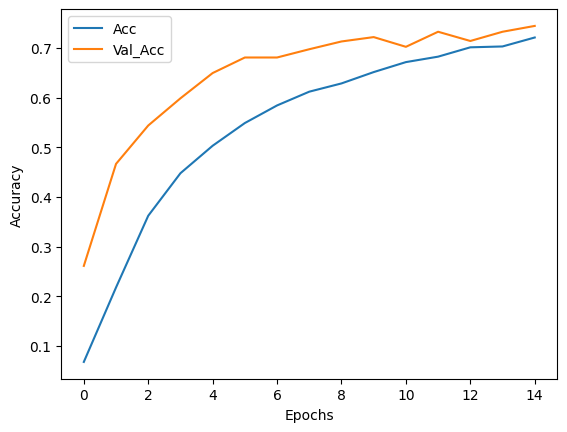

In [30]:
plt.plot(final_model.history.history['acc'])
plt.plot(final_model.history.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'Val_Acc'])

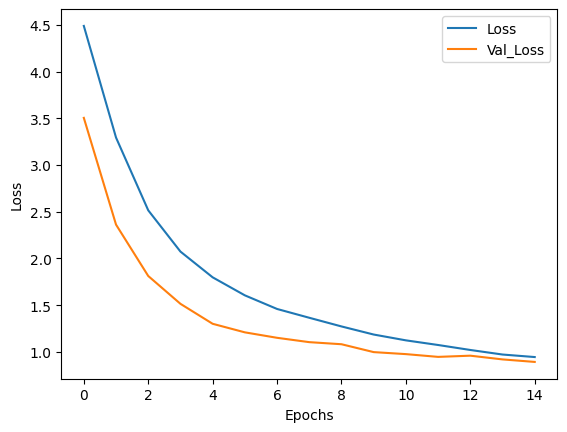

In [31]:
plt.plot(final_model.history.history['loss'])
plt.plot(final_model.history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss', 'Val_Loss'])

In [32]:
#import pickle

In [33]:
#f=open("model.pkl", "wb")

In [34]:
#pickle.dump(final_model, f)

In [35]:
model_json=final_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
final_model.save_weights("model.h5")

In [41]:
loaded_model=tf.keras.models.load_model("Dogbreed")

In [42]:
def predict_image(image, model):
  image=cv2.imread(image)
  plt.imshow(image)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image, (375, 375))

  plt.imshow(image)

  image=np.expand_dims(image, axis=0)

  result=model.predict(image)
  y_pred=np.argmax(result)
  breed=labels[y_pred]

  return breed, result[0][y_pred]*100

In [46]:
#! wget https://gundog-journal.com/siteimg/main/ugc-1/fullnews/news/155/182_original.jpg
'''Scottish-deerhound'''
#download=! wget https://cdn.britannica.com/70/148370-050-87E4E987/Scottish-deerhound.jpg
'''Dingo'''
#download=! wget https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcToEd-zNfDpK1xW-WJjwBzltFEfEe8iXVoOwzDKQf-ki9bT2s8GAm1Ffe4TEuh_fGuxDNayEijfvpF6J-A
'''bluetick'''
#download=! wget https://www.shutterstock.com/image-photo/bluetick-coonhound-standing-by-woods-600w-1051366103.jpg
'''weimaraner'''
download=! wget https://bestforpets.in/wp-content/uploads/2023/07/Weimaraner-price-in-india.jpg

In [47]:
download

['--2023-07-22 08:33:51--  https://bestforpets.in/wp-content/uploads/2023/07/Weimaraner-price-in-india.jpg',
 'Resolving bestforpets.in (bestforpets.in)... 172.67.210.140, 104.21.69.166, 2606:4700:3037::6815:45a6, ...',
 'Connecting to bestforpets.in (bestforpets.in)|172.67.210.140|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 76048 (74K) [image/jpeg]',
 'Saving to: ‘Weimaraner-price-in-india.jpg.1’',
 '',
 '',
 '          Weimarane   0%[                    ]       0  --.-KB/s               ',
 'Weimaraner-price-in 100%[===================>]  74.27K  --.-KB/s    in 0.02s   ',
 '',
 '2023-07-22 08:33:51 (4.01 MB/s) - ‘Weimaraner-price-in-india.jpg.1’ saved [76048/76048]',
 '']

In [48]:
image=download[-2].split()[-3][1:-1]

In [49]:
image

'Weimaraner-price-in-india.jpg.1'

In [50]:
#loaded_model=tf.keras.models.load_model("/content/drive/My Drive/Project/model.h5")

1/1 [==============================] - 3s 3s/step


NameError: ignored

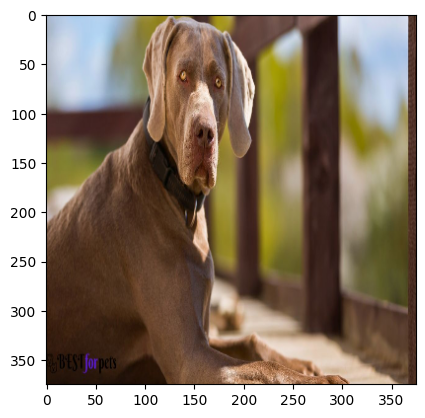

In [51]:
predict_image(image, loaded_model)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Project"

# Write a sample file to Google Drive
with open('/content/drive/My Drive/Project/model.pkl', 'wb') as f:
  pickle.dump(final_model, f)
'''

In [ ]:
'''final_model.save('/content/drive/My Drive/Project/model.h5')'''

In [ ]:
result=loaded_model.predict(image)

1/1 [==============================] - 4s 4s/step


In [ ]:
import numpy as np
labels = df["breed"].to_numpy()
#labels= np.array(labels) # does same thing as above command
unique_breeds = np.unique(labels)
unique_breeds

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
labels

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',
